# Door Dash Case Study

## Hypothesis:
*We anticipate pay rate, job function, location, tenure & total promotions are correlated with employee turnover*

## Method:


- **Part 1** Analytics: Employee insights, key trends and factors driving employee turnover

- **Part 2** Predictive Modeling: 2025 Turnover forecast





# Part 1 Analytics

We want to validate the inputs we will use for our forecast are correlated with turnover, inversely total company tenure.

To do this we will aggregate at the employee level & find the following
- Tenure
    - Total tenure at company
    - Tenure in current role
    - Number of promotions
- Current job factors
    - Job level
    - Job function
    - Location
    - Pay Type


### Library imports

In [191]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

In [193]:
df = pd.read_csv("../Data_Sources/moondash_data.csv") #using relative path to import data
df.head()

,effective_date,employee_id,job_function,location,job_level,employee_status,hire_date,pay_rate_type,role_volume_type
0,2022-03-31,16041,HR,"New York City, New York",L5,Active,2020-08-10,Salary,Low
1,2022-03-31,16449,Sales,"New York City, New York",L6,Active,2020-04-05,Salary,Low
2,2022-03-31,15822,Engineering,"San Francisco, California",L4,Active,2021-12-03,Salary,Low
3,2022-03-31,15417,Sales,"San Francisco, California",L5,Active,2021-08-01,Salary,Low
4,2022-03-31,14944,HR,"San Francisco, California",L4,Active,2021-03-01,Salary,Low


In [195]:
df['effective_date'].max()

'2024-12-31'

### Prepping Data

In [198]:
#converting locations into easier to work with values
df['location'] = df['location'].apply(lambda x: x.split(',')[0].replace(" ", ""))

#same with job function
df['job_function'] = df['job_function'].str.split(' ', n=1).str[0]

#convert dates from strings into datetime
df[['effective_date','hire_date']] = df[['effective_date','hire_date']].apply(pd.to_datetime)

#converting effective dates to quarterly to be used for time series modeling + graphs
df['effective_date'] = df['effective_date'].dt.to_period('Q').dt.start_time

df.head()


,effective_date,employee_id,job_function,location,job_level,employee_status,hire_date,pay_rate_type,role_volume_type
0,2022-01-01,16041,HR,NewYorkCity,L5,Active,2020-08-10,Salary,Low
1,2022-01-01,16449,Sales,NewYorkCity,L6,Active,2020-04-05,Salary,Low
2,2022-01-01,15822,Engineering,SanFrancisco,L4,Active,2021-12-03,Salary,Low
3,2022-01-01,15417,Sales,SanFrancisco,L5,Active,2021-08-01,Salary,Low
4,2022-01-01,14944,HR,SanFrancisco,L4,Active,2021-03-01,Salary,Low


In [199]:
# For each employee, get the maximum tenure corresponding to the max rank
# we find that pay_rate_type & volume type are perfectly correlated, using both is unnessesary
# job level l2 is only associated with hourly L3-10 is associated with salary
# even distributions of role types by location

df_test = df.groupby(['pay_rate_type','location','job_function']).count()
df_test.head(50)


effective_date  employee_id  \
pay_rate_type location     job_function                                
Hourly        MoonMart1    Strategy                8137         8137   
              MoonMart2    Strategy                8250         8250   
              Orlando      Strategy               13529        13529   
Salary        MoonMart1    Strategy                2934         2934   
              MoonMart2    Strategy                3202         3202   
              NewYorkCity  Engineering             5935         5935   
                           Finance                  736          736   
                           HR                       522          522   
                           Sales                    980          980   
              Orlando      Strategy                5948         5948   
              SanFrancisco Engineering             5762         5762   
                           Finance                 2674         2674   
                           HR                       545          545   
                           Sales                    837          837   
              Seattle      Engineering             5937         5937   
                           HR                       712          712   
                           Sales                    899          899   
              Tempe        HR                       605          605   
                           Sales                    856          856   

                                         job_level  employee_status  \
pay_rate_type location     job_function                               
Hourly        MoonMart1    Strategy           8137             8137   
              MoonMart2    Strategy           8250             8250   
              Orlando      Strategy          13529            13529   
Salary        MoonMart1    Strategy           2934             2934   
              MoonMart2    Strategy           3202             3202   
              NewYorkCity  Engineering        5935             5935   
                           Finance             736              736   
                           HR                  522              522   
                           Sales               980              980   
              Orlando      Strategy           5948             5948   
              SanFrancisco Engineering        5762             5762   
                           Finance            2674             2674   
                           HR                  545              545   
                           Sales               837              837   
              Seattle      Engineering        5937             5937   
                           HR                  712              712   
                           Sales               899              899   
              Tempe        HR                  605              605   
                           Sales               856              856   

                                         hire_date  role_volume_type  
pay_rate_type location     job_function                               
Hourly        MoonMart1    Strategy           8137              8137  
              MoonMart2    Strategy           8250              8250  
              Orlando      Strategy          13529             13529  
Salary        MoonMart1    Strategy           2934              2934  
              MoonMart2    Strategy           3202              3202  
              NewYorkCity  Engineering        5935              5935  
                           Finance             736               736  
                           HR                  522               522  
                           Sales               980               980  
              Orlando      Strategy           5948              5948  
              SanFrancisco Engineering        5762              5762  
                           Finance            2674              2674  
                           HR             

#### Tenure
We will be calculating:
- Tenure at company
- Tenure in current role
- Total promotions

The data on record starts in 2022, however employee hire dates are much earlier. 

To calcuate tenure at each job level, we need to adjust for this. To do so we will find the first position we have on file then subtract the effective date from the hire date, if we are at a second or third position, we will use the effective date from the role start date

**NOTE**: we find 26% of data has employee data where recorded effective date is before hire date, in these instances we force the hire date to be equal to the first recorded effective date

In [203]:


#for a given employee what is the first & last record we have on file
hire_caps = df.groupby("employee_id")['effective_date'].agg(['max','min']).reset_index()

#for a given employee/job function/job level, what is the first & last record we have on file
hire_role_caps = df.groupby(["employee_id",'job_function','job_level'])['effective_date'].agg(['max','min'])

#get set of associates who's hire date is before first recorded entry
wrong_hires_dt = df[['effective_date','employee_id']][df['effective_date'] < df['hire_date']]

#attaching adjusted hire date from our min/max effective dates across the entire dataset
df_adj = pd.merge(
    wrong_hires_dt, 
    hire_caps[['employee_id', 'min']], 
    on='employee_id', 
    how='inner'
).drop(columns = 'effective_date').rename(columns = {'min':'adj_hire_dt'})

#joining on our adjusted dates to main df
df_adj2 = pd.merge(
    df, 
    df_adj, 
    on='employee_id', 
    how='left'
)

#overwrite our bad effective dates, if we have a value in adj_hire_dt use that, otherwise leave as is
df_adj2['hire_date'] = df_adj2['adj_hire_dt'].fillna(df_adj2['hire_date'])
df_adj2[df_adj2['employee_id'] ==16624]

,effective_date,employee_id,job_function,location,job_level,employee_status,hire_date,pay_rate_type,role_volume_type,adj_hire_dt
2001,2022-04-01,16624,HR,Tempe,L4,Active,2022-04-01,Salary,Low,2022-04-01
4001,2022-07-01,16624,HR,Tempe,L4,Active,2022-04-01,Salary,Low,2022-04-01
6002,2022-10-01,16624,HR,Tempe,L4,Active,2022-04-01,Salary,Low,2022-04-01
8001,2023-01-01,16624,HR,Tempe,L4,Active,2022-04-01,Salary,Low,2022-04-01
10251,2023-04-01,16624,HR,Tempe,L4,Terminated,2022-04-01,Salary,Low,2022-04-01


In [205]:

#map in dates into our main data frame
df_ten = pd.merge(df_adj2,hire_caps, how = "inner",on="employee_id").rename(columns={"max": "end_dt", "min": "start_date"})
df_ten2 = pd.merge(df_ten,hire_role_caps, how = 'inner', on = ['employee_id','job_function','job_level']).rename(columns={"max": "end_role_date", "min": "start_role_date"})

# Creating number of promotions a given employee had
df_ten2['rank'] = df_ten2.groupby('employee_id')['start_role_date'].rank(method='dense', ascending=True)
df_ten2['rank_max'] = df_ten2.groupby('employee_id')['rank'].transform('max')

df_ten2['role_tenure'] = np.where(df_ten2['rank'] == 1, #if this is your first role, use time - hire date
                     df_ten2['effective_date'] - df_ten2['hire_date'], 
                     df_ten2['effective_date'] - df_ten2['start_role_date'])#otherwise use time - role start date

#find total tenure
df_ten2['total_tenure'] = df_ten2['effective_date'] - df_ten2['hire_date']
#employee 12 started in 2021 but first record is in 2022
#first role tenure starts at 153 then ratchets up
#next role tenure starts at 0 then increases
df_ten2[df_ten2['employee_id'] ==12].sort_values(by = 'effective_date').head()

,effective_date,employee_id,job_function,location,job_level,employee_status,hire_date,pay_rate_type,role_volume_type,adj_hire_dt,end_dt,start_date,end_role_date,start_role_date,rank,rank_max,role_tenure,total_tenure
31767,2022-01-01,12,Strategy,MoonMart2,L2,Active,2021-10-29,Hourly,High,NaT,2024-10-01,2022-01-01,2022-07-01,2022-01-01,1.0,2.0,64 days,64 days
31768,2022-04-01,12,Strategy,MoonMart2,L2,Active,2021-10-29,Hourly,High,NaT,2024-10-01,2022-01-01,2022-07-01,2022-01-01,1.0,2.0,154 days,154 days
31769,2022-07-01,12,Strategy,MoonMart2,L2,Active,2021-10-29,Hourly,High,NaT,2024-10-01,2022-01-01,2022-07-01,2022-01-01,1.0,2.0,245 days,245 days
31770,2022-10-01,12,Strategy,MoonMart2,L3,Active,2021-10-29,Salary,Low,NaT,2024-10-01,2022-01-01,2024-10-01,2022-10-01,2.0,2.0,0 days,337 days
31771,2023-01-01,12,Strategy,MoonMart2,L3,Active,2021-10-29,Salary,Low,NaT,2024-10-01,2022-01-01,2024-10-01,2022-10-01,2.0,2.0,92 days,429 days


For our correlation matrix we will want the total company tenure, tenure in current role, & total number of promotions

In [208]:
# Filter the rows where rank is equal to max_rank and get the corresponding tenure
df_max_rank_tenure = df_ten2[df_ten2['rank'] == df_ten2['rank_max']]

# For each employee, get the maximum tenure corresponding to the max rank
tenure = df_max_rank_tenure.groupby('employee_id').agg(
    max_tenure=('total_tenure', 'max'),  # Max tenure corresponding to max rank
    max_role_tenure=('role_tenure', 'max'),  # Max rank for each employee
    max_promotions=('rank_max', 'max')  # Max rank for each employee
).reset_index()

# pulling in the employee status for the latest value
df_max_effective_date = df_ten2.loc[df_ten2.groupby('employee_id')['effective_date'].idxmax()]

# Merge the employee status with the tenure data
tenure_final = pd.merge(
    tenure, 
    df_max_effective_date[['employee_id', 'employee_status']], 
    on='employee_id', 
    how='left'
)

tenure_final[tenure_final['employee_id'] ==12]


,employee_id,max_tenure,max_role_tenure,max_promotions,employee_status
11,12,1068 days,731 days,2.0,Active


#### Current Role
We will be calculating:
- Job level
- Job function
- Location
- Pay Type

We want to use the current role as this will be a driving factor if an associate leaves the company or not. It is unlikely that a previous role would be a deciding factor for leaving the company

In [211]:
#filtering for active associates
active = df_adj2[df_adj2['employee_status'] == 'Active']

#find the job function/level/pay rate/location for last recorded active role
active_final = active.loc[
    active.groupby('employee_id')['effective_date'].idxmax(), 
    ['employee_id', 'employee_status', 'effective_date', 'job_function','job_level', 'pay_rate_type','location']
].drop(columns = ['employee_status']) #we want to see correlation to final status,not only active roles


active_final[active_final['employee_id'] ==12]


,employee_id,effective_date,job_function,job_level,pay_rate_type,location
65933,12,2024-10-01,Strategy,L3,Salary,MoonMart2


#### Combining Tenure values with Current Role 
We will:
- combine at the employee level
- apply 1-hot-encoding for our categorical variables
- review correlation matrix 

In [264]:
#merging data frames, now at the employee id level
#saving this df off as it will be primary input for ML model
df_corr = pd.merge(active_final,tenure_final, how = "inner",on="employee_id")

#converting tenure from datetime into int
df_corr[['max_tenure', 'max_role_tenure']] = df_corr[['max_tenure', 'max_role_tenure']].apply(lambda x: x.dt.days)
df_corr.to_csv('../Data_Sources/ML_input.csv', index=False) 

df_corr[df_corr['employee_id'] == 12 ]

,employee_id,effective_date,job_function,job_level,pay_rate_type,location,max_tenure,max_role_tenure,max_promotions,employee_status
7,12,2024-10-01,Strategy,L3,Salary,MoonMart2,1068,731,2.0,Active


In [266]:
#applying 1hot encoding
df_corr2 = pd.get_dummies(df_corr, columns=['employee_status','job_function', 'pay_rate_type', 'location','job_level'], drop_first=False)


df_corr2[df_corr['employee_id'] == 12]

,employee_id,effective_date,max_tenure,max_role_tenure,max_promotions,employee_status_Active,employee_status_Terminated,job_function_Engineering,job_function_Finance,job_function_HR,...,location_Tempe,job_level_L10,job_level_L2,job_level_L3,job_level_L4,job_level_L5,job_level_L6,job_level_L7,job_level_L8,job_level_L9
7,12,2024-10-01,1068,731,2.0,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


### Correlation Matrix Findings
- We find the follwing are most correlated with employee termination
    -  OpsStrategy
    -  Job Level L2 (Hourly)
    -  MoonMart1
- These factors have high collinearity with each other
    - Typically an hourly associate will work in MoonMart1 & be in OpsStrategy
- Our final dataset will choose Job Level in lieu of pay rate type

**Correlation Matrix (All Associates)**

In [220]:
corr = df_corr2.drop(columns = ['effective_date','employee_id','employee_status_Active']).corr()

corr[['employee_status_Terminated']].sort_values(by = 'employee_status_Terminated',ascending = False)

,employee_status_Terminated
employee_status_Terminated,1.000000
job_function_Strategy,0.216215
job_level_L2,0.208196
pay_rate_type_Hourly,0.208196
location_MoonMart1,0.082649
location_Orlando,0.081011
location_MoonMart2,0.072253
job_function_Sales,0.050671
location_Tempe,0.017787
max_role_tenure,0.000111


**Correlation Matrix (Hourly/L2)**

In [223]:
df_corr2[['pay_rate_type_Hourly','job_function_Strategy','job_level_L2','location_MoonMart1']].corr()

,pay_rate_type_Hourly,job_function_Strategy,job_level_L2,location_MoonMart1
pay_rate_type_Hourly,1.000000,0.67736,1.000000,0.216909
job_function_Strategy,0.677360,1.00000,0.677360,0.306770
job_level_L2,1.000000,0.67736,1.000000,0.216909
location_MoonMart1,0.216909,0.30677,0.216909,1.000000


**Correlation Matrix (Salary/L3 +)**

In [226]:
#looking at terminated employees for L3 + associates
df_corr_sal = df_corr[df_corr['job_level'] > 'L2']

##redoing one hot encoding 
df_corr_sal2 = pd.get_dummies(df_corr_sal, \
                              columns=['employee_status','job_function', 'pay_rate_type', 'location','job_level'], drop_first=False)
##getting correlation matrix & dropping irrelvant columns
corr_sal = df_corr_sal2.drop(columns = ['effective_date','employee_id','employee_status_Active']).corr()

##new correlation matrix
corr_sal[['employee_status_Terminated']].sort_values(by = 'employee_status_Terminated',ascending = False)

,employee_status_Terminated
employee_status_Terminated,1.000000
job_function_Sales,0.143754
job_function_Strategy,0.142265
job_level_L3,0.142265
location_MoonMart1,0.074874
location_Orlando,0.072572
location_Tempe,0.068420
location_MoonMart2,0.062427
job_function_HR,0.040600
job_level_L4,0.007603


In [302]:
##new correlation matrix
corr_sal[['max_tenure']]
# .sort_values(by = 'employee_status_Terminated',ascending = False)

,max_tenure
max_tenure,1.000000
max_role_tenure,0.858823
max_promotions,0.420153
employee_status_Terminated,-0.047222
job_function_Engineering,0.215555
job_function_Finance,0.079532
job_function_HR,0.003653
job_function_Sales,-0.015199
job_function_Strategy,-0.249523
pay_rate_type_Salary,NaN


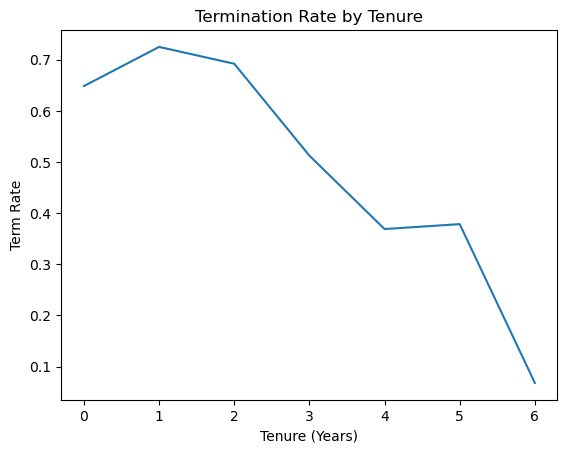

In [300]:
# Rename 'employee_status_Terminated' to 'Termination Rate'
# df_corr2 = df_corr2.rename(columns={'employee_status_Terminated': 'Termination Rate'})

df_corr2['max_tenure_yr'] = round(df_corr2['max_tenure']/365,2)
df_corr2['Termination Rate'] = df_corr2['employee_status_Terminated']
df_corr2[['max_tenure_yr', 'Termination Rate']].astype(int).groupby('max_tenure_yr').mean().plot()

# Add labels and title
plt.legend().set_visible(False)
plt.xlabel('Tenure (Years)')
plt.ylabel('Term Rate')
plt.title('Termination Rate by Tenure')

# Show the plot
# Save the plot as an image
plt.savefig('../Output_Files/tenure_term_rate.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()